In [56]:
from foamdapy.tools import *
from foamdapy import EnSim
import matplotlib.pyplot as plt

# 関数定義
## extract_val
CaseDir,time,cell_indxを指定して変数を読み取る関数

In [2]:
# unit test extract_val
!head -n 26 ./mixerVessel2D/6/U.water | tail -n 5

u_xyz = extract_val("./mixerVessel2D", "6", ["U.water"], [0,2])
u_xyz

3072
(
(0.0343983 0.217795 0)
(0.0549077 0.205497 0)
(0.0679317 0.193151 -3.1551e-26)


array([ 3.43983e-02,  6.79317e-02,  2.17795e-01,  1.93151e-01,
        0.00000e+00, -3.15510e-26])

## cell_distance
各セル間の距離を表すマトリクス

In [3]:
mat_d = cell_distance("./mixerVessel2D")
mat_d.shape, mat_d.max(),mat_d.min(),mat_d[:4,:4]

((3072, 3072),
 0.19740489282145468,
 0.0,
 array([[0.        , 0.00139142, 0.00278135, 0.00416829],
        [0.00139142, 0.        , 0.00139142, 0.00278134],
        [0.00278135, 0.00139142, 0.        , 0.00139141],
        [0.00416829, 0.00278134, 0.00139141, 0.        ]]))

array([[1.        , 0.99751898, 0.99012329, 0.97795357],
       [0.99751898, 1.        , 0.99751897, 0.99012338],
       [0.99012329, 0.99751897, 1.        , 0.99751903],
       [0.97795357, 0.99012338, 0.99751903, 1.        ]])

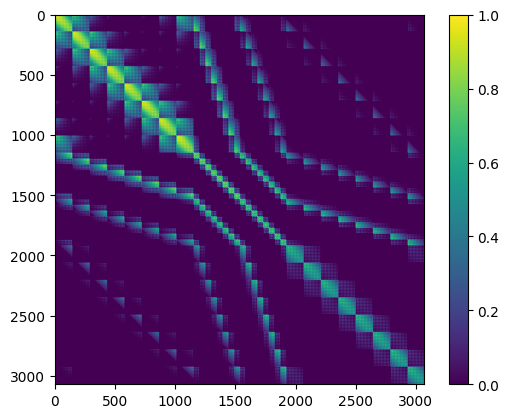

In [4]:

localizemat = localizemat(mat_d, 0.1)
im = plt.imshow(localizemat)
plt.colorbar(im)
localizemat[:4,:4]

## invR_nonZero
idx番のcellに対して、観測indexesのinvRと影響0でないcellindexesを返す

In [5]:
%%time
invR, nzero = invR_nonZero(localizemat, 0,np.array([0,3066,3071,3072,3073]))
invR,nzero,invR[:,nzero][nzero]

CPU times: user 1.86 ms, sys: 0 ns, total: 1.86 ms
Wall time: 1.8 ms


(array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.]]),
 array([ True, False, False,  True, False]),
 array([[1., 0.],
        [0., 1.]]))

In [8]:
invR_nonZero(0,np.array([0,3066,3071,3072,3073]))

TypeError: invR_nonZero() missing 1 required positional argument: 'obs_indexes'

In [7]:
import time
start = time.perf_counter()
localizemat = localizemat 
idx = 0
obs_indexes=np.array([0,3066,3071,3072,3073])

t0 = time.perf_counter()

obs_indexes = obs_indexes.reshape(1, -1)[0]
min_index = (idx // len(localizemat)) * len(localizemat)
max_index = min_index + len(localizemat)

t1 = time.perf_counter()

limmin = obs_indexes < min_index
limmax = obs_indexes > max_index

t2 = time.perf_counter()

idx = idx % len(localizemat)
obs_indexes = obs_indexes % len(localizemat)


t3 = time.perf_counter()

invR = np.identity(len(obs_indexes))
invR *= localizemat[idx][obs_indexes].T
invR[limmin] = 0.0
invR[limmax] = 0.0


t4 = time.perf_counter()

indx_nozero = invR.max(axis=1) > 0


t5 = time.perf_counter()


t10 = t1 -t0
t21 = t2 -t1
t32 = t3 - t2
t43 = t4 - t3
t54 = t5 -t4
t50 = t5 - t0

t10, t21, t32, t43, t54, t50

(0.000113999999484804,
 0.000869800000145915,
 0.0001584999999977299,
 0.00029240000003483146,
 0.0001289000001634122,
 0.0015635999998266925)

# cell_indies_layer
外周層のcell listを取得する関数

In [7]:
cxyz = extract_val("./mixerVessel2D", "0", ["C"])
cxyz = cxyz.reshape(3,-1).T
n_2layer = cell_indies_layer(2, cxyz).shape[0]
n_1layer = cell_indies_layer(1, cxyz).shape[0]
n_2layer, n_1layer

(192, 96)

# pickup_rewite
cell list以外を任意の値に変更して、OFの変数ファイルを再作成する関数

In [8]:
# unit test
read_file = "./mixerVessel2D/6/U.water"
write_file = "./U.water_test"
cells = [0, 2]
pickup_rewite(read_file, write_file, cells)
!head -n 28 ./mixerVessel2D/6/U.water | tail -n 7
!head -n 50 ./U.water_test | tail -n 38

3072
(
(0.0343983 0.217795 0)
(0.0549077 0.205497 0)
(0.0679317 0.193151 -3.1551e-26)
(0.0788192 0.181221 -2.7115e-26)
(0.0888831 0.169962 4.08827e-27)
dimensions [ 0 1 -1 0 0 0 0 ];

internalField nonuniform List<vector> 3072
(

  3
  (
    0.0343983
    0.217795
    0.0
  )

  3
  (
    2.0
    2.0
    2.0
  )

  3
  (
    0.0679317
    0.193151
    -3.1551e-26
  )

  3
  (
    2.0
    2.0
    2.0
  )

  3
  (
    2.0
    2.0
    2.0


#　update_of
da後の変数をOFの変数ファイルに下記戻す関数

In [9]:
#unit test
case_path = "./mixerVessel2D"
time_name = "6test"
x_names = ["U.water","alpha.water"]
x_data = extract_val("./mixerVessel2D", "5", ["U.water","alpha.water"])
update_of(x_data, case_path, time_name, x_names)
x_data_new = extract_val("./mixerVessel2D", "6test", ["U.water","alpha.water"])
False in (x_data_new == x_data)

False

### ケースの状態を管理するクラス

## main

In [2]:
import os
os.getpid()


21473

In [5]:
import random
from foamdapy import EnSim
random.seed(0)

n_cells = 3072
x_names = ["U.air", "U.water","alpha.water", "T.air","T.water", "p_rgh"]
n_x_scaler = 10
y_names = ["U.air", "U.water","alpha.water", "T.air","T.water", "p_rgh"]
n_y_scaler = 10 #ベクトル問題解決までは = n_xscaler
n_ensemble = 20

n_obs_cells = n_cells//2
obs_cells = random.sample(range(n_cells), n_obs_cells)
obs_cells.sort()

ensim = EnSim("./ensim3/", "ofsim_", x_names, n_x_scaler, n_cells, n_ensemble, y_names,n_y_scaler, obs_cells, "./ensim3/mixerVessel2D.obs",4)

In [6]:
import numpy as np
ensim.xf = np.load("ensim3/06_xf.npy")
ensim.y0 = np.load("ensim3/06_y0.npy")

In [7]:
ensim.num_cpus=1
ensim.letkf_update()

  0%|          | 0/30720 [00:00<?, ?it/s]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [7]:
ensim.y0.shape

(15360,)

In [17]:
ensim.ensemble_forcast("6")
ensim.xf

array([[3.27800e-02, 5.34311e-02, 6.64453e-02, ..., 1.66530e+05,
        1.66530e+05, 1.66530e+05],
       [3.28561e-02, 5.35050e-02, 6.65049e-02, ..., 1.66530e+05,
        1.66530e+05, 1.66530e+05],
       [3.28508e-02, 5.35483e-02, 6.65798e-02, ..., 1.66529e+05,
        1.66529e+05, 1.66529e+05],
       ...,
       [3.28714e-02, 5.35417e-02, 6.65472e-02, ..., 1.66529e+05,
        1.66529e+05, 1.66529e+05],
       [3.27714e-02, 5.34774e-02, 6.65187e-02, ..., 1.66529e+05,
        1.66529e+05, 1.66529e+05],
       [3.27657e-02, 5.33583e-02, 6.63437e-02, ..., 1.66529e+05,
        1.66529e+05, 1.66529e+05]])

In [18]:
ensim.observation("6")
ensim.y0

array([3.25851e-02, 5.34777e-02, 6.68498e-02, ..., 1.66518e+05,
       1.66518e+05, 1.66518e+05])

In [19]:
ensim.letkf_update()

2024-02-12 08:32:44,907	INFO worker.py:1724 -- Started a local Ray instance.
E0212 08:32:45.972765900    6165 socket_utils_common_posix.cc:224]     check for SO_REUSEPORT: UNKNOWN:Protocol not available {created_time:"2024-02-12T08:32:45.972442499+09:00", errno:92, os_error:"Protocol not available", syscall:"getsockopt(SO_REUSEPORT)"}


(raylet) Warning: The remote function __main__.xaj is very large (72 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(raylet) E0212 08:32:49.791483300    6641 socket_utils_common_posix.cc:224]     check for SO_REUSEPORT: UNKNOWN:Protocol not available {syscall:"getsockopt(SO_REUSEPORT)", os_error:"Protocol not available", errno:92, created_time:"2024-02-12T08:32:49.791152+09:00"}
(raylet) E0212 08:32:51.114737600    6672 socket_utils_common_posix.cc:224]     check for SO_REUSEPORT: UNKNOWN:Protocol not available {created_time:"2024-02-12T08:32:51.1144051+09:00", errno:92, os_error:"Protocol not available", syscall:"getsockopt(SO_REUSEPORT)"}
(raylet) E0212 08:32:56.665889400    6773 socket_utils_common_posix.cc:224]     check for SO_REUSEPORT: UNKNOWN:Protocol not available {created_time:"2024-02-12T08:32:56.6655129+09:00", errno:92, os_error:"Protocol not available", syscall:"getsockopt(SO_REUSEPORT)"} [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplica

(pid=6641)  0:   0%|          | 0/30720 [00:00<?, ?it/s]

(raylet) E0212 08:33:22.176365200    7004 socket_utils_common_posix.cc:224]     check for SO_REUSEPORT: UNKNOWN:Protocol not available {created_time:"2024-02-12T08:33:22.175985+09:00", errno:92, os_error:"Protocol not available", syscall:"getsockopt(SO_REUSEPORT)"}
(raylet) E0212 08:33:24.103181700    7037 socket_utils_common_posix.cc:224]     check for SO_REUSEPORT: UNKNOWN:Protocol not available {syscall:"getsockopt(SO_REUSEPORT)", os_error:"Protocol not available", errno:92, created_time:"2024-02-12T08:33:24.1027863+09:00"}


OutOfMemoryError: Task was killed due to the node running low on memory.

Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.

In [20]:
np.save("ensim/06_xa.npy",ensim.xa)
np.save("ensim/06_xf.npy",ensim.xf)
np.save("ensim/06_y0.npy",ensim.y0)
ensim.limit_alpha_in_xa()


NameError: name 'bkup_time_name' is not defined

In [23]:

time_name = "6"
bkup_time_name = f"{6-0.001}"
ensim.bkup_time_dir(time_name, bkup_time_name)
ensim.update_cases(time_name)
np.save("ensim/06a_xa.npy",ensim.xa)
np.save("ensim/06a_xf.npy",ensim.xf)
np.save("ensim/06a_y0.npy",ensim.y0)

Error: [(<DirEntry 'functionObjects'>, './ensim/ofsim_0/5.999/uniform/functionObjects', "[Errno 13] Permission denied: './ensim/ofsim_0/5.999/uniform/functionObjects'"), (<DirEntry 'uniform'>, './ensim/ofsim_0/5.999/uniform', "[Errno 13] Permission denied: './ensim/ofsim_0/5.999/uniform'"), ('./ensim/ofsim_0/6', './ensim/ofsim_0/5.999', "[Errno 13] Permission denied: './ensim/ofsim_0/5.999'")]

In [31]:
for i in range(9):
    t = round(6.1 + i*0.1,1)
    time_name = f"{t}"
    bkup_time_name = f"{t-0.001}"
    print(f"start: {time_name}")
    ensim.ensemble_forcast(time_name)
    ensim.observation(time_name)
    ensim.letkf_update()
    ensim.bkup_time_dir(time_name, bkup_time_name)
    ensim.update_cases(time_name)

  0%|          | 0/9 [00:00<?, ?it/s]

start: 6.1


/tmp/ipykernel_1313/3606723025.py:80: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def xaj(j, y_indexes, dyf, nmem, y0,H, xf,xfa, dxf):


  0%|          | 0/30720 [00:00<?, ?it/s]

/tmp/ipykernel_1313/3606723025.py:79: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "xaj" failed type inference due to: Invalid use of type(CPUDispatcher(<function invR_nonZero at 0x7f36fdf90ee0>)) with parameters (int64, array(int64, 1d, C))

During: resolving callee type: type(CPUDispatcher(<function invR_nonZero at 0x7f36fdf90ee0>))
During: typing of call at /tmp/ipykernel_1313/3606723025.py (81)


File "../../../../tmp/ipykernel_1313/3606723025.py", line 81:
<source missing, REPL/exec in use?>

  @jit
/home/katayamata/pyenv/3.9.7/py39/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "xaj" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_1313/3606723025.py", line 79:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/katayamata/pyenv/3.9.7/py39/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDepr

KeyboardInterrupt: 

## 計算フロー
1. アンサンブル計算のcaseファイルの準備(手動)
2. 変数の初期値を入手
3. アンサンブル時間発展計算(controlDict編集 ./run_step)
4. 観測データの入手
5. アンサンブルアップデート
6. Trueデータとの比較(精度)
7. 3に戻る



# 観測データの準備

## 最外周のCell変数を取得する

In [18]:
import numpy as np
from foamdapy.tools import letkf_update
np.random.seed(0)
num_ensenble = 40
num_obs = 2

xf = np.stack(
    [
        np.random.normal(0.0, 1, num_ensenble),
        np.random.normal(1.0, 2, num_ensenble),
        np.random.normal(2.0, 1, num_ensenble),
    ],
    axis=1,
)
H = np.array([[0, 1, 0], [0, 0, 1]])

t0 = xf * 2.0
y0 = t0[:, -num_obs:].mean(axis=0)
y_indexes = np.array([1, 2])
lmat = np.full((3, 3), 1.0)
num_cpu = 1
xa_loop = letkf_update(xf, H, y0, y_indexes, lmat, num_cpu)
xa1 = xa_loop.copy()
for i in range(500):
    xa_loop = letkf_update(xa_loop, H, y0, y_indexes, lmat, num_cpu)

100%|██████████| 3/3 [00:00<00:00, 589.20it/s]


In [19]:
xf.mean(axis=0),xf.std(axis=0)

(array([0.31254247, 0.25274592, 2.45891981]),
 array([1.06433386, 1.62030472, 1.04537042]))

In [20]:
xa_loop.mean(axis=0),xa_loop.std(axis=0)

(array([-1.69125947e+96,  5.04815447e-01,  4.91329376e+00]),
 array([2.60903432e+98, 4.40979032e-02, 4.40743614e-02]))

In [17]:
y0

array([0.50549183, 4.91783961])

In [47]:
num_cpu = 2
xa2 = letkf_update(xf, H, y0, y_indexes, lmat, num_cpu)

2024-03-30 13:49:07,113	INFO worker.py:1724 -- Started a local Ray instance.


In [31]:
np.random.seed(0)
num_cpu = 2
xa_parallel = letkf_update(xf, H, y0, y_indexes, lmat, num_cpu)

2024-03-30 13:31:12,631	INFO worker.py:1724 -- Started a local Ray instance.


In [54]:
(np.round(xa1.mean(axis=0),9) == np.round(xa2.mean(axis=0),9)).all()

True

In [29]:
xa.mean(axis=0),xa.std(axis=0)

(array([0.14164134, 2.13044572, 2.87982822]),
 array([2.62104148, 4.25829064, 1.59864348]))

In [30]:
xa_parallel.mean(axis=0),xa_parallel.std(axis=0)

(array([0.3647451 , 2.13044572, 2.87982822]),
 array([3.60378485, 4.25829064, 1.59864348]))

In [61]:
import numpy.matlib as mb

In [63]:
mb.repmat

<function numpy.matlib.repmat(a, m, n)>